In [76]:
import os
import json
import yaml
import pandas as pd
from pprint import pprint

from glob import glob
from PIL import Image

from shutil import copyfile

import matplotlib.pyplot as plt
from matplotlib import rc  ### 이 줄과
rc('font', family='AppleGothic') 			## 이 두 줄을 
plt.rcParams['axes.unicode_minus'] = False  ## 추가해줍니다. 
pd.set_option('future.no_silent_downcasting', True)

from ultralytics import YOLO

In [2]:
IMG_BASE_DIR = "../data/ai03-level1-project/train_images"
ANNOTATION_DIR = "../data/ai03-level1-project/train_annotations"
ann_folder_list = os.listdir(ANNOTATION_DIR)
ann_folder_list = sorted(ann_folder_list)

# category_id_map: { "19860": "노바스크정 5mg", ... }
with open("../Project/data_csv/mappings.json", "r") as f:
    mappings = json.load(f)

# YOLO class index -> class name
with open("../data/ai03-level1-project/data.yaml", "r") as f:
    yaml_data = yaml.safe_load(f)
yolo_classes = yaml_data["names"]

# class name -> category_id
name_to_catid = {v: int(k) for k, v in mappings["category_id_map"].items()}

# YOLO index → category_id
yolo_idx_to_catid = {i: name_to_catid[name] for i, name in enumerate(yolo_classes)}

model = YOLO("../best.pt")

In [ ]:
# annotations 폴더 이름으로 유추해 빈 json 파일 만들기 
def make_loss_file():
  model.eval()
  
  # train_annotations/K-003544-012247-016548-027926_json
  for folder_name in ann_folder_list:
    # [003544, 012247, 016548, 027926]
    keys = (folder_name.split("_json")[0]).split("-")[1:]

    # train_annotations/K-003544-012247-016548-027926_json/K-003544
    target_path = os.path.join(ANNOTATION_DIR, folder_name)

    # [K-003544, K-012247, K-016548, K-027926]
    target_folders = os.listdir(target_path)

    if len(keys) != len(target_folders):
      # 폴더 자체가 없는경우는 메모만
      print(f"len(keys) != len(target_folders) {folder_name}")

    for target_folder_name in target_folders:
      # 003544
      if target_folder_name.split("-")[1] in keys:
        path3 = os.path.join(target_path, target_folder_name)

        # [.json]
        json_files = os.listdir(path3)
        if len(json_files) == 0:
          continue
        elif len(json_files) < 3:
          try:
            current_keys = [(i.split("0_2_0_2_")[1]).split("_000_")[0] for i in json_files]
          except:
            print("except key: ", folder_name)
            current_keys = [(i.split("0_2_1_2_")[1]).split("_000_")[0] for i in json_files]

          for current_key in ["70", "75", "90"]:
            if current_key not in current_keys:
              origin_filepath = os.path.join(path3, json_files[0])
              copy_filename = f"{(json_files[0].split('_000_')[0][:-2])}{current_key}_000_200"
              copy_filepath = os.path.join(path3, f"{copy_filename}.json")
              
			  # 이미지가 없으면 패스
              if not os.path.exists(f"{IMG_BASE_DIR}/{copy_filename}.png"):
                continue
              
              copyfile(origin_filepath, copy_filepath)

              with open(copy_filepath, "r", encoding="utf-8") as f:
                ann = json.load(f)
              # 값 수정
              ann["images"][0]["file_name"] = f"{copy_filename}.png"
              ann["images"][0]["imgfile"] = f"{copy_filename}.png"
              
			  # image_id 값 찾기
              image_id = None
              for i in target_folders:
                if i != target_folder_name:
                  ref_file = os.path.join(target_path, i, f"{copy_filename}.json")
                  if os.path.exists(ref_file):
                    with open(ref_file, "r", encoding="utf-8") as f:
                      ref_ann = json.load(f)
                      
                      image_id = ref_ann["annotations"][0]["image_id"]
                      break
              if image_id is None:
                print("=========", path3)
                return
              
              ann["images"][0]["id"] = image_id
              ann["annotations"][0]["image_id"] = image_id
			
              # 추론
              results = model(f"{IMG_BASE_DIR}/{copy_filename}.png", conf=0.5)
              for i, box in enumerate(results[0].boxes):
                class_id = int(box.cls[0])
                conf = float(box.conf[0])
                x1, y1, x2, y2 = map(int, box.xyxy[0])
                
                if ann["annotations"][0]["category_id"] == yolo_idx_to_catid.get(class_id):
                  ann["annotations"][0]["bbox"] = [x1, y1, x2-x1, y2-y1]
              
			  # JSON 파일 덮어쓰기
              with open(copy_filepath, "w", encoding="utf-8") as f:
                  json.dump(ann, f, indent=4, ensure_ascii=False)
                  

results = make_loss_file()

len(keys) != len(target_folders) K-002483-003743-012081-022627_json
len(keys) != len(target_folders) K-002483-005094-012081-019552_json
len(keys) != len(target_folders) K-002483-012081-023223-025438_json
len(keys) != len(target_folders) K-003351-019232-020238_json
except key:  K-003351-019232-029667_json
except key:  K-003351-019232-029667_json
except key:  K-003351-019232-029667_json
len(keys) != len(target_folders) K-003483-016232-020877-022347_json
len(keys) != len(target_folders) K-003483-016232-022347-027653_json
len(keys) != len(target_folders) K-003483-016232-027653-031885_json
len(keys) != len(target_folders) K-003483-016232-027653-034597_json
len(keys) != len(target_folders) K-003483-016262-020877-022347_json
len(keys) != len(target_folders) K-003483-016262-027733-031885_json
len(keys) != len(target_folders) K-003483-019861-028763-029667_json
len(keys) != len(target_folders) K-003483-025469-034597-035206_json
len(keys) != len(target_folders) K-003483-027653-031885-036637_json


In [64]:
# 이미지와 어노테이션을 로드하는 헬퍼 함수
def load_image_and_annotations(image_filename, img_base_dir, annotation_base_dir):
    img_path = os.path.join(img_base_dir, image_filename)
    image = Image.open(img_path).convert("RGB")
    
	# 어노테이션 파일 경로 구성 로직 수정
    # 예: K-001900-010224-016551-031705_0_2_0_2_70_000_200.png
    # -> K-001900-010224-016551-031705_json/K-001900/K-001900-010224-016551-031705_0_2_0_2_70_000_200.json
    # 첫 번째 디렉토리 이름 (예: K-001900-010224-016551-031705_json)
    # 이미지 파일명에서 첫 번째 '_' 앞부분을 추출하고 '_json'을 붙임
    base_id_part = image_filename.split('_')[0]
    annotation_dir_name = base_id_part + '_json'
    
	# 두 번째 디렉토리 이름 (예: K-001900)
    # base_id_part에서 첫 번째 '-'와 두 번째 '-' 사이의 부분을 추출
    # K-001900-010224-016551-031705 -> ['K', '001900', '010224', '016551', '031705'] -> 'K-001900'
    annotation_file_name = image_filename.replace('.png', '.json')
    
    bboxes = []
    labels = []
    for key in base_id_part.split('-'):
        if 'K' == key.upper():
            continue

        annotation_sub_dir_name = f"K-{key}"
        
		# 최종 JSON 파일명은 이미지 파일명과 동일 (확장자만 .json)
        json_path = os.path.join(annotation_base_dir, annotation_dir_name, annotation_sub_dir_name, annotation_file_name)
        if os.path.exists(json_path):
            with open(json_path, 'r', encoding='utf-8') as f:
                annotation_data = json.load(f)
            if 'annotations' in annotation_data:
                for ann in annotation_data['annotations']:
                    bbox = ann.get('bbox') # [x, y, width, height]
                    category_id = ann.get('category_id')
                    if bbox and category_id is not None:
                        # Find the corresponding category name
                        category_name = next((cat['name'] for cat in annotation_data.get('categories', []) if cat['id'] == category_id), str(category_id))
                        bboxes.append(bbox)
                        labels.append(category_name)
        else:
            print(f"Warning: Annotation file not found for {image_filename} at {json_path}")
    return image, bboxes, labels

# 바운딩 박스와 라벨을 이미지에 그리는 헬퍼 함수
def draw_boxes_on_image(ax, image, bboxes, labels):
    ax.imshow(image)
    ax.set_axis_off()

    for bbox, label in zip(bboxes, labels):
        x, y, w, h = bbox
        rect = plt.Rectangle((x, y), w, h, fill=False, edgecolor='red', linewidth=2)
        ax.add_patch(rect)
        ax.text(x, y - 10, label, color='red', fontsize=12, bbox=dict(facecolor='white', alpha=0.7, edgecolor='none', pad=0))

In [62]:
def bbox_l1_distance(box1, box2):
    """
    box1, box2: [x, y, w, h] 형식
    리턴: L1 distance (총 차이 정도)
    """
    x1, y1, w1, h1 = box1
    x2, y2, w2, h2 = box2

    dx = abs(x1 - x2)
    dy = abs(y1 - y2)
    dw = abs(w1 - w2)
    dh = abs(h1 - h2)

    return dx + dy + dw + dh

# train annotations 파일과 추론한 이미지의 바운딩박스 차이 계산
def find_outbindding_box():
  model.eval()

  image_files = os.listdir(IMG_BASE_DIR)
  image_files = sorted(image_files)
  
  output_results = []
  for image_file in image_files:
    # 어노테이션의 바운딩박스
    filename_str = image_file.split("_")
    target_dir = os.path.join(ANNOTATION_DIR, f"{filename_str[0]}_json")
    target_key = filename_str[5]
    json_list = glob(f"{target_dir}/**/*{target_key}_000_200.json")
    
    results = model(f"{IMG_BASE_DIR}/{image_file}", conf=0.5)
    
    for json_path in json_list:
      with open(json_path, "r", encoding="utf-8") as f:
        ann = json.load(f)
        # 모델의 바운딩박스
        for i, box in enumerate(results[0].boxes):
          class_id = int(box.cls[0])
          conf = float(box.conf[0])
          x1, y1, x2, y2 = map(int, box.xyxy[0])
          if ann["annotations"][0]["category_id"] == yolo_idx_to_catid.get(class_id):
            l1_dist = bbox_l1_distance([x1, y1, x2-x1, y2-y1], ann["annotations"][0]["bbox"])
            if l1_dist > 100:
              output_results.append({
                "image": image_file,
                "bbox": [x1, y1, x2-x1, y2-y1],
                "class_id": class_id
        	  })
            break
          
  return output_results
    # if "K-001900-016548-018110-021026_0_2_0_2_70_000_200.png" == image_file:
    #   return


output = find_outbindding_box()


image 1/1 /Users/kimjaeyong/Documents/study/toy_projects/meditation-detection-project/scripts/../data/ai03-level1-project/train_images/K-001900-010224-016551-031705_0_2_0_2_70_000_200.png: 640x512 1 보령부스파정 5mg, 1 동아가바펜틴정 800mg, 1 낙소졸정 500/20mg, 90.8ms
Speed: 1.6ms preprocess, 90.8ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 512)

image 1/1 /Users/kimjaeyong/Documents/study/toy_projects/meditation-detection-project/scripts/../data/ai03-level1-project/train_images/K-001900-010224-016551-031705_0_2_0_2_75_000_200.png: 640x512 1 보령부스파정 5mg, 1 동아가바펜틴정 800mg, 1 낙소졸정 500/20mg, 93.5ms
Speed: 1.5ms preprocess, 93.5ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 512)

image 1/1 /Users/kimjaeyong/Documents/study/toy_projects/meditation-detection-project/scripts/../data/ai03-level1-project/train_images/K-001900-010224-016551-031705_0_2_0_2_90_000_200.png: 640x512 1 보령부스파정 5mg, 1 동아가바펜틴정 800mg, 1 자누메트정 50/850mg, 1 낙소졸정 500/20mg, 91.2ms
Speed: 1.5ms preprocess, 91.2

In [133]:
idx = 0

print(len(output), idx)
pprint(output[idx])

19 0
{'bbox': [124, 105, 336, 479],
 'class_id': 29,
 'image': 'K-002483-003743-004378-019552_0_2_0_2_75_000_200.png'}


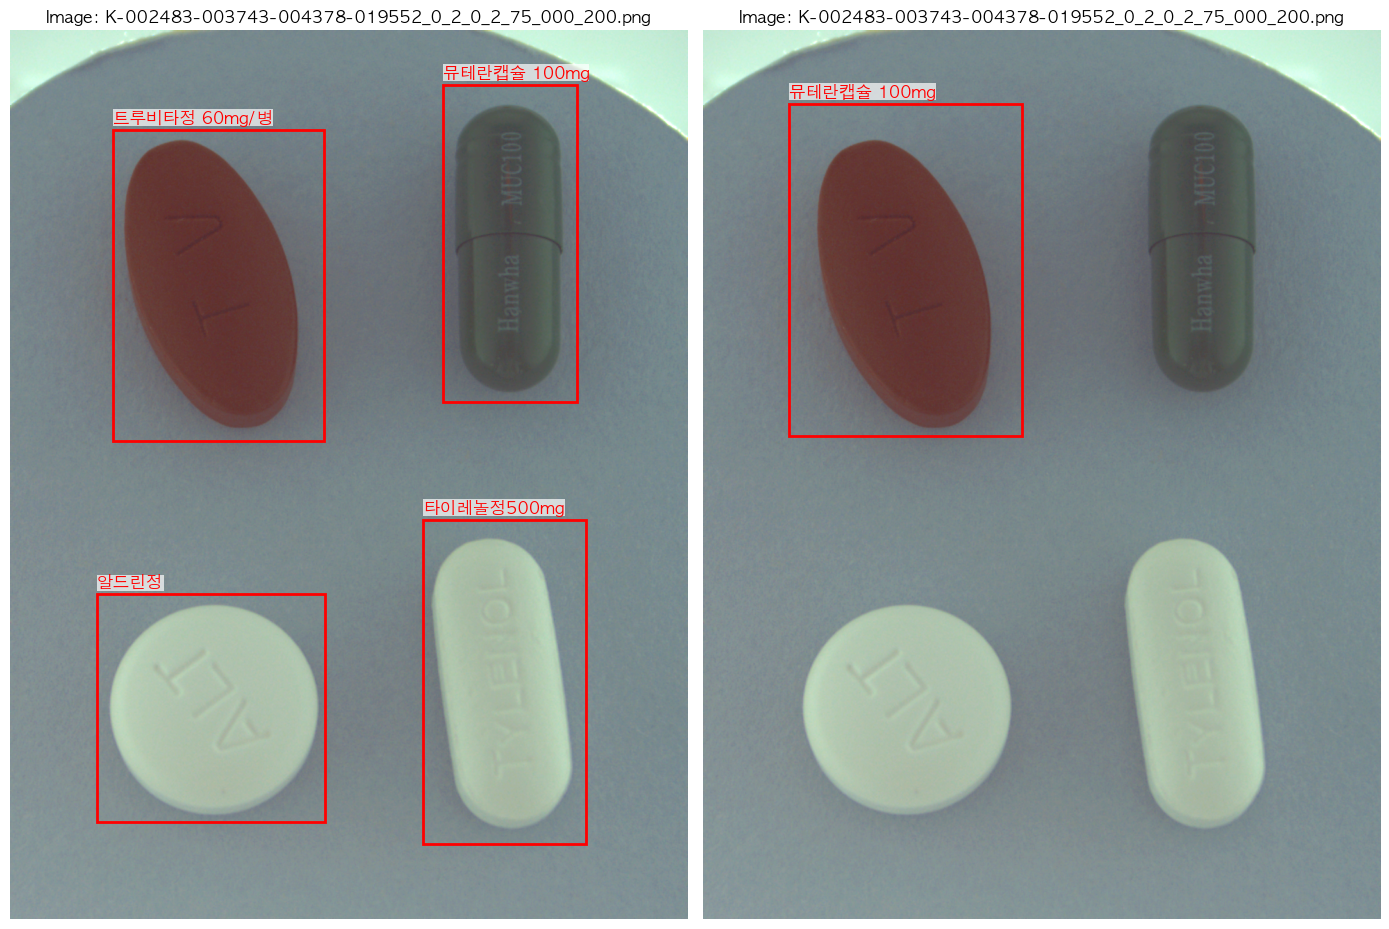

In [134]:
image_filename = output[idx].get("image")

plt.figure(figsize=(14, 10)) # Adjust figure size as needed
image, bboxes, labels = load_image_and_annotations(image_filename, IMG_BASE_DIR, ANNOTATION_DIR)
ax = plt.subplot(1, 2, 1)
draw_boxes_on_image(ax, image, bboxes, labels)
ax.set_title(f"Image: {image_filename}") # Display first drug name if available

# plt.figure(figsize=(20, 5 * 1))
ax = plt.subplot(1, 2, 2)
draw_boxes_on_image(ax, image, [output[idx].get("bbox")], labels)
ax.set_title(f"Image: {image_filename}") # Display first drug name if available

plt.tight_layout()
plt.show()